# Laboratory #05 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive to access the images.

---

In [1]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import io, data, color
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt

**Exercise #1:**

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Make sure that the values of the integral image are correct.
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [2]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))


    # Add code here
    image_ = img_arr.copy()
    for i in range(image_.ndim):
        image_ = image_.cumsum(axis=i)
    integral_image_arr[1:, 1:] = image_

    return integral_image_arr

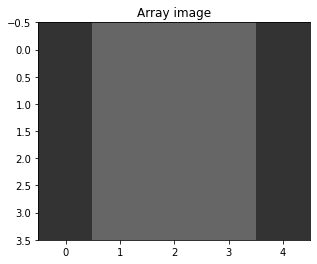

In [3]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()

In [4]:
ii_img_array = compute_integral_image(img_array)
print(img_array)
print(ii_img_array)

[[1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

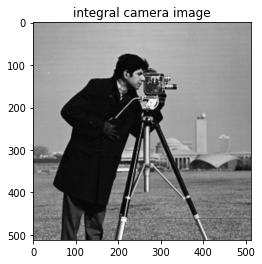

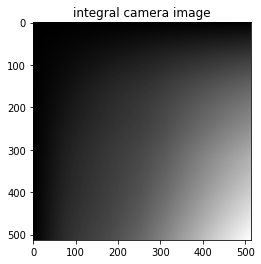

In [5]:
# solution
cameraImage = data.camera()
iiCameraImage = compute_integral_image(cameraImage)

plt.imshow(cameraImage, cmap="gray")
plt.title("integral camera image")
plt.show()

plt.imshow(iiCameraImage, cmap="gray")
plt.title("integral camera image")
plt.show()

**Exercise #2:**

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [6]:
def sum_region(integral_img_arr, top_left, bottom_right):
    point1 = integral_img_arr[top_left[0], top_left[1]]
    point2 = integral_img_arr[bottom_right[0], top_left[1]]
    point3 = integral_img_arr[top_left[0], bottom_right[1]]
    point4 = integral_img_arr[bottom_right[0], bottom_right[1]]
    return point1 + point4 - (point2 + point3)

*   Make the following tests:

In [7]:
# result you should get (12)
sum_region(ii_img_array, [1, 1], [3, 4])

12.0

In [8]:
# result you should get (32)
sum_region(ii_img_array, [0, 0], [-1, -1])

32.0

**Exercise #3:**

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [9]:
from skimage.util import img_as_float

def load_integral_images(path):
    ii_images = []
    for _file in os.listdir(path):
        #### Complte here:
        #### Read image
        #### Remember to scale the images (with the max pixel intensity value)
        if os.path.splitext(_file)[-1] != '.png':
            continue
        image = io.imread(os.path.join(path, _file))
        image = img_as_float(image)
        image /= image.max()
        ii_images.append(compute_integral_image(image))
    return ii_images


# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

In [10]:
# change paths to your location

pos_training_path = 'images/train_data/faces'
neg_training_path = 'images/train_data/non_faces'
pos_testing_path = 'images/test_data/faces'
neg_testing_path = 'images/test_data/non_faces'

*   Visualize a few original images and the corresponding integral images using matplotlib.

In [11]:
# solution
posTrainingIntegralImages = load_integral_images(pos_training_path)
negTrainingIntegralImages = load_integral_images(neg_training_path)
posTestingIntegralImages = load_integral_images(pos_testing_path)
negTestingIntegralImages = load_integral_images(neg_testing_path)

**Exercise 4:**

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [12]:
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')

    t0 = time.time()
    
    features = []
    
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.
                for x in range(img_height - feature_height - 1):
                    for y in range(img_width - feature_width - 1):
                        pPolarityFeature = HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1)
                        nPolarityFeature = HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1)
                        features = features + [pPolarityFeature, nPolarityFeature]
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    
    return features

In [13]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [14]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [15]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=os.cpu_count())
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                ########################
                ### FILL IN HERE
                ########################
                for x in range(img_height - feature_height - 1):
                    for y in range(img_width - feature_width - 1):
                        pPolarityFeature = HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1)
                        nPolarityFeature = HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1)
                        features = features + [pPolarityFeature, nPolarityFeature]
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features

**Exercise #5:**

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [16]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [17]:
%%time
positive_iis = posTrainingIntegralImages
negative_iis = negTrainingIntegralImages 
classifiers = learn(positive_iis,
                    negative_iis,
                    num_classifiers=num_classifiers,
                    min_feature_width=min_feature_width,
                    max_feature_width=max_feature_width,
                    min_feature_height=min_feature_height,
                    max_feature_height=max_feature_height)

Creating Haar-like features..
	2090 features created.
	Time needed for calculating Harr-like features: 0.006434917449951172
Calculating scores for images..
	Time needed for calculating scores: 74.87951707839966
Selecting classifiers..
	Time needed for Selecting Classifiers: 37.47798776626587 

CPU times: user 1min 41s, sys: 7.4 s, total: 1min 48s
Wall time: 1min 52s


**Exercise #6:**

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [34]:
# solution
def ensemble_vote(int_img, classifiers):
    votes = list(map(lambda classifier: classifier.get_vote(int_img), classifiers))
    positiveVotes = np.sum(np.array(votes) >= 0)
    return int(positiveVotes >= len(votes)//2)

def ensemble_vote_all(int_imgs, classifiers):
    return list(map(lambda item: ensemble_vote(item, classifiers), int_imgs))

positiveVotesTrain = ensemble_vote_all(posTrainingIntegralImages, classifiers)
negativeVotesTrain = ensemble_vote_all(negTrainingIntegralImages, classifiers)
positiveVotesTest = ensemble_vote_all(posTestingIntegralImages, classifiers)
negativeVotesTest = ensemble_vote_all(negTestingIntegralImages, classifiers)

template = "train results:\n\
Correctly identified Faces: {0}/{1}  ({2:.4f}%)\n\
Correctly identified non-Faces: {3}/{4}  ({5:.4f}%)\n\n\
test results:\n\
Correctly identified Faces: {6}/{7}  ({8:.4f}%)\n\
Correctly identified non-Faces: {9}/{10}  ({11:.4f}%)"
print(template.format(
    sum(positiveVotesTrain),
    len(positiveVotesTrain),
    100*sum(positiveVotesTrain)/len(positiveVotesTrain),
    sum(negativeVotesTrain),
    len(negativeVotesTrain),
    100*sum(negativeVotesTrain)/len(negativeVotesTrain),
    sum(positiveVotesTest),
    len(positiveVotesTest),
    100*sum(positiveVotesTest)/len(positiveVotesTest),
    sum(negativeVotesTest),
    len(negativeVotesTest),
    100*sum(negativeVotesTest)/len(negativeVotesTest)
))

train results:
Correctly identified Faces: 2411/2429  (99.2590%)
Correctly identified non-Faces: 7075/8548  (82.7679%)

test results:
Correctly identified Faces: 464/472  (98.3051%)
Correctly identified non-Faces: 109/128  (85.1562%)


*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [ ]:
# solution



**Exercise #7:**

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [ ]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time 
#classifiers_20 = learn(...)

*   Discuss if the classification results improved in the train data.


**Solution**

*(Double-click or enter to edit)*

...

**Exercise #8:**

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [ ]:
# solution



*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [ ]:
# solution



*   Make a bar plot for 1-4. In the x axis write the threshold value.

In [ ]:
# solution



*   Discuss what happens when you increase the threshold value.

**Solution**

*(Double-click or enter to edit)*

...

# Face Recognition

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

In [ ]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 100

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

In [ ]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

In [ ]:
# Train a SVM classification model

print("Fitting the classifier to the training set")

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

In [ ]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()

y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

In [ ]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [ ]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

**Exercise #1:**

*   Show the total percentage of variance explained by the selected components of the PCA.


In [ ]:
# solution



**Exercise #2:**

*   Explain all the measures showed in the classification report.
*   Discuss the obtained classification results, the quantitative as well as the qualitative results.
*   Comment the showed eigenfaces.



**Solution**

*(Double-click or enter to edit)*

...

**Exercise #3:**

*   Change the strategy for dimensionality reduction from PCA to LDA. 
*   *Hint: You can use sklearn.discriminant_analysis.LinearDiscriminantAnalysis*

In [ ]:
# solution



*   How many dimensions are we obtaining in the new space? Why?
*   Comment the results and compare them with the ones obtained with PCA.
*   Explain which is the main difference between the two approaches.

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P5: Face Detection and Recognition**
Deadline for P5 submission in CampusVirtual is: **Thursday, the 12th of November, 2020**